In [1]:
import sys
sys.path.append('..')
import umbrella_mesh
import linkage_vis
import load_jsondata
from configuration import *
from visualization_helper import *

In [2]:
import numpy as np

In [3]:
sys.path.append('../UmbrellaGen')
import grid_gen

### Define the grid dimensions and Umbrella Valence you want

In [4]:
degree = 3 # 3 for TriUmbrellas, 4 for QuadUmbrellas
rows = 5 # please make sure rows >=2
cols = 5 # please make sure cols >=2

In [5]:
numUmbrellas = 0
if degree == 3:
    numUmbrellas = (rows * 2) * cols
elif degree == 4 or degree == 6:
    numUmbrellas = rows * cols

### Define your favorite height, material and cross-section     #-------function! Umbrellas are sequenced row-wise

In [6]:
def myHeightFunc(numUmbrellas): 
    heights = [1] * numUmbrellas # Scale Factor of heights. Set minHeight to your desired minimum absolute height.
    for uid in range(numUmbrellas):
        heights[uid] += (0.1 * uid**1.6 + 0.1 *(numUmbrellas - 1 - uid)**1.6)
        # heights[uid] += (0.01 * uid**3 + 0.01 *(numUmbrellas - 1 - uid)**3)
    print(min(heights))
    heights = [h/min(heights) for h in heights]
    # print(np.array(heights)*64)
    return heights

def myMaterialFunc(numUmbrellas):
    plate_E, plate_nu, plate_thickness, plate_width = [1400 * 10, 0.35, 3.0, 5.0]
    E = [1400] * numUmbrellas #Default values for uniform material umbrellas
    nu = [0.35] * numUmbrellas
    thickness = [3.0] * numUmbrellas
    width = [5.0] * numUmbrellas
    
    # Write your material function here dependent on UmbrellaID (uid). In the visualization below the colormap (viridis) will help you visualize the IDs. They are sequenced row-wise
    #-------
    for uid in range(numUmbrellas):
        # E[uid] += -2000 + 0.05 * (  uid ** 3 + (numUmbrellas - 1 - uid)**3 )
        # nu[uid] += 0.01 * uid
        thickness[uid] += 0.1 * uid
        width[uid] += 0.1 * uid
    #-------
        
        
    material_params = np.zeros((1 + 4 * (numUmbrellas + 1)))
    material_params[0] = numUmbrellas + 1
    material_params[1::4] = E + [plate_E]
    material_params[2::4] = nu + [plate_nu]
    material_params[3::4] = thickness + [plate_thickness]
    material_params[4::4] = width + [plate_width]
    
    return material_params
    

In [7]:
# The height function is a scaling function relative to the minHeight
minHeight = 64
V, F, X, _ = grid_gen.genUmbrellaWithHeights(degree, rows, cols, height_scales = myHeightFunc(numUmbrellas),minHeight = minHeight)

34.40277486269047


In [23]:
V, F = np.array(V), np.array(F)

C = V[F].mean(axis=1)

np.unique(np.round(np.linalg.norm(np.expand_dims(C, 1) - V[F], axis = -1), decimals = 7)).size == 1

1

In [8]:
import mesh
base_mesh = mesh.Mesh("../../data/plane_equi.obj")
V, F = base_mesh.vertices(), base_mesh.elements()
V_3d = np.zeros((len(V), 3))
V_3d[:, :2] = V
c_out = V_3d[F].mean(axis=1)

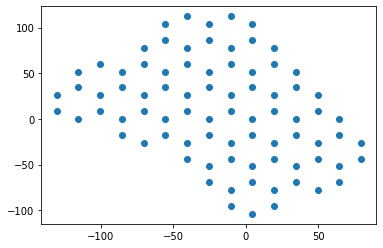

In [9]:
import matplotlib.pyplot as plt
plt.scatter(c_out[:,0],c_out[:,1])

In [11]:
import importlib
importlib.reload(grid_gen)
_, _, X_fin, _ = grid_gen.genUmbrellaWithHeights(degree, rows, cols, height_scales = None,minHeight = minHeight, base_mesh = (V_3d.tolist(),F.tolist()))

### Initialization

In [12]:
name = 'grid_dump'
input_path = '../UmbrellaGen/{}.json.gz'.format(name)
io1, input_data1, target_mesh, curr_um1, plate_thickness, target_height_multiplier = parse_input(input_path, handleBoundary = False, isHex = (degree == 6))


In [13]:
rod_colors1 = get_color_field(curr_um1, input_data1, uidBased = False) 

from ipywidgets import HBox
lview1 = linkage_vis.LinkageViewer(curr_um1, width=800, height=600)
lview1.update(scalarField = rod_colors1)
lview1.show()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(PointLight(color='#999999', position=(0…

### Deploy umbrellaMesh

In [14]:
success = deploy_umbrella_pin_rigid_motion(curr_um1, plate_thickness, target_height_multiplier, lview1, rod_colors1)

### Align Views appropriately

In [ ]:
# assert 0
# lview1.setCameraParams(lview2.getCameraParams())
lview2.setCameraParams(lview1.getCameraParams())

In [ ]:
V1, F1, _ = curr_um1.visualizationGeometry()
V2, F2, _ = curr_um2.visualizationGeometry()
V3 = np.vstack((V1, V2))
F3 = np.vstack((F1, F2 + len(V1)))

import vis
from matplotlib import cm
bending1, bending2 = curr_um1.maxBendingStresses(), curr_um2.maxBendingStresses()
bvmin, bvmax = np.min(bending1 + bending2), np.max(bending1 + bending2)
print(bvmin, bvmax)
twisting1, twisting2 = curr_um1.twistingStresses(), curr_um2.twistingStresses()
tvmin, tvmax = np.min(twisting1 + twisting2), np.max(twisting1 + twisting2)
print(tvmin, tvmax)

print(np.array(bending1).shape)
print(np.max(bending1), np.max(bending2))
print(np.max(twisting1), np.max(twisting2))


print((np.max(bending2) - np.max(bending1))/np.max(bending1))
print((np.max(twisting2) - np.max(twisting1))/np.max(twisting1))


pos1 = np.array([curr_um1.segment(sid).rod.deformedPoints() for sid in range(curr_um1.numSegments())])
pos2 = np.array([curr_um2.segment(sid).rod.deformedPoints() for sid in range(curr_um2.numSegments())])
distance = np.linalg.norm(pos2 - pos1, axis = -1)


print(distance.shape, len(bending1), curr_um1.numSegments(), curr_um1.numJoints())

sf1b = vis.fields.ScalarField(curr_um1, bending1, colormap = cm.plasma, vmin = bvmin, vmax = bvmax)
sf2b = vis.fields.ScalarField(curr_um2, bending2, colormap = cm.plasma, vmin = bvmin, vmax = bvmax)
sf1t = vis.fields.ScalarField(curr_um1, twisting1, colormap = cm.plasma, vmin = tvmin, vmax = tvmax)
sf2t = vis.fields.ScalarField(curr_um2, twisting2, colormap = cm.plasma, vmin = tvmin, vmax = tvmax)

sfd = vis.fields.ScalarField(curr_um2, distance, colormap = cm.plasma)


color1b, color2b = sf1b.colors(), sf2b.colors()
color1t, color2t = sf1t.colors(), sf2t.colors()
color1d, color2d = np.ones_like(sfd.colors())*0.5, sfd.colors()

bcolors = np.vstack((color1b, color2b))
tcolors = np.vstack((color1t, color2t))
dcolors = np.vstack((color1d, color2d))
bview, tview, dview = linkage_vis.LinkageViewer((V3, F3)), linkage_vis.LinkageViewer((V3, F3)), linkage_vis.LinkageViewer((V3, F3))
bview.update(scalarField = bcolors)
tview.update(scalarField = tcolors)
dview.update(scalarField = dcolors)
HBox([bview.show(), tview.show(), dview.show()])

In [ ]:
tview.setCameraParams(bview.getCameraParams())
dview.setCameraParams(bview.getCameraParams())
assert 0

### Max vonMises Stress Visualization

In [ ]:
lview1.update(scalarField = curr_um1.maxVonMisesStresses())
lview2.update(scalarField = curr_um2.maxVonMisesStresses())

### Release actuation forces to see if there is a bistable state

In [ ]:
deploy_umbrella_pin_rigid_motion(curr_um1, plate_thickness, target_height_multiplier, lview1, rod_colors1, releaseActuation = True)

In [ ]:
deploy_umbrella_pin_rigid_motion(curr_um2, plate_thickness, target_height_multiplier, lview2, rod_colors2, releaseActuation = True)